In [1]:
import torch
import numpy as np 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
from search_parameter import *
import optuna
from CIFAR10_model import *
from CIFAR10_data_preparation import *

/home/bluefog/miniconda3/envs/bf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
A=R
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=cifar10_prepare_node_5_hard_shuffled()

A的第二大特征值: 4.965068306494546e-17
A的beta: 2.0584085788909642e-16
A的spectral gap: 0.9999999999999998
A的kappa: 1.0000000000000007
S_A是: 4.472135954999583 

1.0000e+00, 5.0000e+00


Training Progress: 100%|██████████| 500/500 [3:38:34<00:00, 26.23s/it, accuracy=73.7900000000%, epoch=500, loss=0.2181158226]  


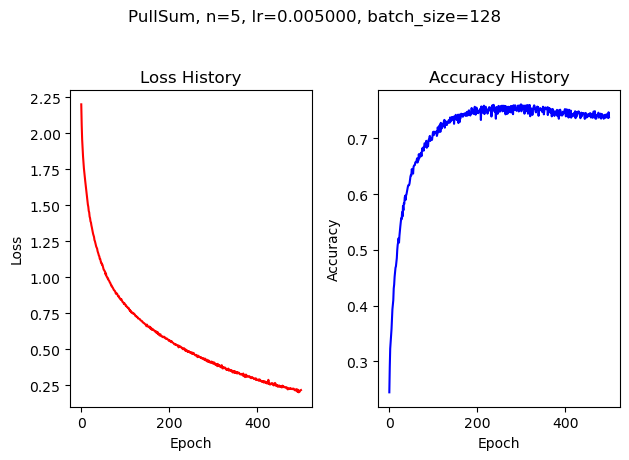

In [4]:
Sum_l1, Sum_a1 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,#0.14534766737788476,
    batch_size=128,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [1:36:51<00:00, 11.62s/it, accuracy=39.0600000000%, epoch=500, loss=1.7025604010]


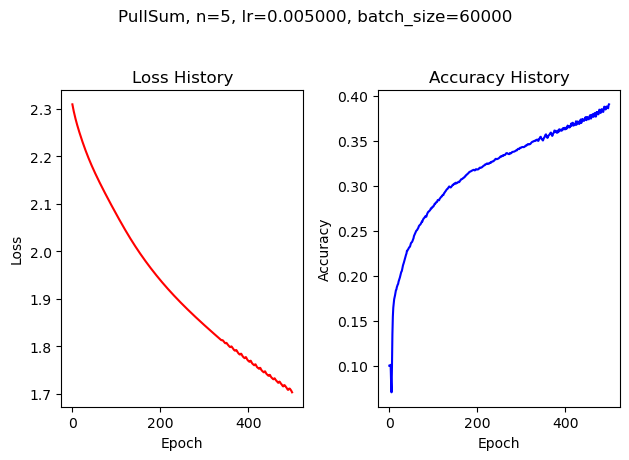

In [5]:
Sum_l2, Sum_a2 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,#0.14534766737788476,
    batch_size=60000,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

In [6]:
Sum_l3, Sum_a3 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,#0.14534766737788476,
    batch_size=64,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress:  16%|█▌        | 79/500 [1:04:44<5:44:59, 49.17s/it, accuracy=72.8200000000%, epoch=79, loss=0.7003954241]


KeyboardInterrupt: 